# Simple feed forward Neural Network

Init by importing `numpy` (this is mainly used) and `matplotlib` (only used to show the convergence). 
Note we make use of some `@staticmethods` which have been grouped by there activation function (e.g. Sigmoid, TANH), this way it allows for modular implementation of the activation function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class SigmoidActivation:
    @staticmethod
    def forward(input) -> np.array:
        ex = np.exp(input)
        return ex / (ex + 1)
    
    @staticmethod
    def backward(input) -> np.array:
        sigmoid = SigmoidActivation.forward(input)
        return sigmoid * (1 - sigmoid)
    
class TanhActivation:
    @staticmethod
    def forward(input) -> np.array:
        ex = np.exp(input)
        ex_min = np.exp(-1*input)
        return (ex - ex_min) / (ex + ex_min)
    
    @staticmethod
    def backward(input) -> np.array:
        return None # not implemented yet
    
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# This function is used to check the activation function selected for the NN (if exists and if yes return the right object)
def checkActivation(activation_func) -> object:
    if activation_func == "sigmoid":
            activation = SigmoidActivation
    elif activation_func == "tanh":
        activation = TanhActivation
    else:
        raise AttributeError("Chosen activation function does not exist.")
    return activation

Here we define the `layer` class which is the most simple form of the Neural Network. In this case it has been chosen to vectorise each layer. So each node is a position an `ndarray` where the value is the weight of the node.

Furthermore, the `getLayer` method has been implemented to return the weights of the layer (getter func) and the `compute` method does the operations to calculate the output of the layer given an input.

In [2]:
class layer:
    def __init__(self, numberOfInputs: int, numberOfNodes: int):
        self.weigths = np.random.rand(numberOfInputs, numberOfNodes)
        self.bias = np.random.rand(numberOfNodes)

    def getLayer(self):
        return(self.weigths)
    
    def compute(self, inputs: np.array, activation: object) -> np.array:
        W = np.dot(inputs, self.weigths) + self.bias
        return  activation.forward(W)

Below the `FFN` class (Feed Forward Network) has been defined. This is a rather complex class so I will break it down method by method. In general the class represents a simple neural nerwork as an `object`. This object holds all layers (which in turn hold als weights and biases) of the network AND the methods defined in the class can be used to do operations on the network.

1. **init method** 

The init method is used to initialise a network. This is done by passing the dimentions of network where the position of the array corrosponds to a layer and the value corrosponds to the number of neurons in each layer (e.g. [3, 3, 1] -> 3 layers, where; layer 1 = 3 neurons; layer 2 = 3 neurons; layer 3 = 1 neuron). 
Additionally, activation function can be chosen (by default sigmoid) and an learning rate (alpha). 

2. **forward method**

The forward method does a forward pass through the network given a valid input. This can be seen as the `.fit` method in the tensorflow lib. 

3. **backward method**

The backlward method does backprogagation of the network. 
**TODO** Write how this is being done!

4. **train method**

The train method is a wrapper of the backward method with some additional features. It uses the `backward method` to train the model in a _for-loop_ so that the model can be easly trained multiple itterations and an implementation which takes a set number of samples of the loss and prediction which is than displayed in a plot.

In [21]:
class FFN:
    def __init__(self, dimensions: list[int], activation="sigmoid", alpha=1) -> None:
        if len(dimensions) < 2:
            raise AssertionError("Network must have at least two layers (input and output).")
        
        self.activation = checkActivation(activation_func=activation)
        self.learningRate = alpha

        self.layers = []
        input_dim = dimensions[0]
        for i in range(1, len(dimensions)):
            layer_dim = dimensions[i]
            self.layers.append(layer(input_dim, layer_dim))
            input_dim = layer_dim

    def forward(self, input: list[float]) -> list[float]:
        activation = input
        for layer in self.layers:
            activation = layer.compute(activation, self.activation)
        return activation
        
    def backward(self, input: list[float], y_true: list[float]) -> None:
        store_impulse = [input]
        current_output = input

        for layer in self.layers:
            current_output = layer.compute(current_output, activation=self.activation)
            store_impulse.append(np.array(current_output)) 

        y_pred = store_impulse[-1]
        error = y_pred - y_true
        delta = error * self.activation.backward(y_pred)

        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            activation_layer = store_impulse[i]

            activation_layer = np.array(activation_layer).reshape(1, -1)
            delta = delta.reshape(1, -1)


            layer.weigths -= self.learningRate * np.dot(activation_layer.T, delta)
            layer.bias -= self.learningRate * np.sum(delta, axis=0)

            if i > 0:
                delta = np.dot(delta, layer.weigths.T) * self.activation.backward(activation_layer)

    def train(self, X: list[float], y: list[float], max_itteratios=1000, graph_points=100) -> None:
        prediction = []
        loss = []
        for i in range(max_itteratios):
            self.backward(input=X, y_true=y)

            if i % (max_itteratios // graph_points) == 0:
                prediction.append(self.forward(X))
                loss.append(self.forward(X) -  y)
                #print(f"Training Itteration: {i}; Loss: {loss[-1]}") 

        plt.plot(list(range(0, max_itteratios, max_itteratios // graph_points)), np.mean(loss, axis=1))
        plt.xlabel("Itterations")
        plt.ylabel("Loss")
        plt.title("Training Loss over Itterations")
        plt.grid()
        plt.show()    

        #return prediction, loss

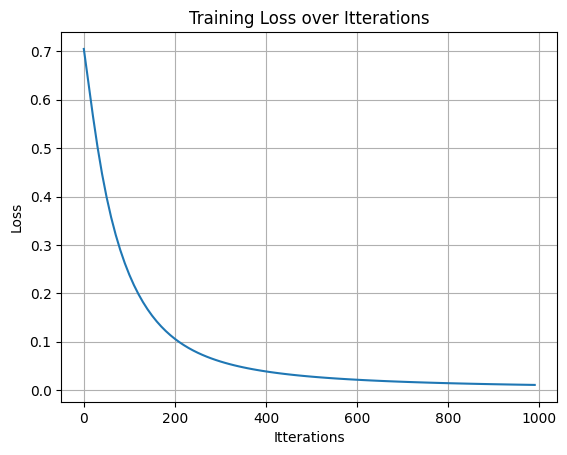

In [40]:
input_value = [0, 0, 0, 1, 0, 0, 0, 0]
correct_output_value = input_value

Network = FFN([8, 3, 8], alpha=0.1)
Network.train(X = input_value, y = correct_output_value, max_itteratios=1000, graph_points=100)

In [41]:
y_pred = Network.forward(input_value)

print(f"Y_true: {correct_output_value} \nY_pred: {y_pred}")

Y_true: [0, 0, 0, 1, 0, 0, 0, 0] 
Y_pred: [0.0129889  0.01338458 0.01447685 0.98788904 0.01413709 0.01469445
 0.01435038 0.01404402]
